Material : <b>Big Data</b><br> 
Done by :<br> - <b>Mehdi AMOR OUAHMED</b><br> - <b>Hamza BERRABAH</b><br> - <b>Ouassim Abdelmalek GHRIBI</b>
<br> Class : <b>2 DSIA</b>  <br> Year : <b>2022-2023</b><br>
# Project : The application of an LSTM architecture on the Sentiment140 dataset <br>

## Importing used librairies

In [1]:
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import string

from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import IndexToString
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.ml.classification import JavaWrapper
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

## Starting a Spark session

In [3]:
spark = SparkSession.builder.appName("Projet_BDM").getOrCreate()

In [4]:
spark

## Importing the dataset in a pyspark form

In [5]:
df = spark.read.csv("sentiment140.csv", inferSchema=True).toDF("sentiment", "id", "date", "query", "user", "text")

In [6]:
df.show(3)

+---------+----------+--------------------+--------+---------------+--------------------+
|sentiment|        id|                date|   query|           user|                text|
+---------+----------+--------------------+--------+---------------+--------------------+
|        0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|        0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|        0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
+---------+----------+--------------------+--------+---------------+--------------------+
only showing top 3 rows



In [7]:
df.printSchema() 

root
 |-- sentiment: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



## Preprocessing

### Null values

In [8]:
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,sentiment,id,date,query,user,text
0,0,0,0,0,0,0


### Columns' data types

In [9]:
df.dtypes

[('sentiment', 'int'),
 ('id', 'bigint'),
 ('date', 'string'),
 ('query', 'string'),
 ('user', 'string'),
 ('text', 'string')]

### Keeping only the text and sentiment columns

In [10]:
drop_cols= ("id","date","query","user")
df = df.drop(*drop_cols)

In [11]:
df.printSchema()

root
 |-- sentiment: integer (nullable = true)
 |-- text: string (nullable = true)



### Verification of unique sentiment values

In [12]:
df.select("sentiment").distinct().show()

+---------+
|sentiment|
+---------+
|        0|
|        4|
+---------+



`0` is negative and `4` is positive

### Target Modeling
`0` for négative and `1` for positive (binary classification)

In [13]:
df.createOrReplaceTempView('temporaire')
df = spark.sql('SELECT CASE sentiment WHEN 4 THEN 1.0  ELSE 0 END AS target, text FROM temporaire')
df.show(5, truncate = False)

+------+-------------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                               |
+------+-------------------------------------------------------------------------------------------------------------------+
|0.0   |@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|0.0   |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|0.0   |@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          |
|0.0   |my whole body feels itchy and like its on fire                                                                     |
|0.0   |@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.     |


In [14]:
df.groupBy("target").count().show()

+------+------+
|target| count|
+------+------+
|   0.0|800000|
|   1.0|800000|
+------+------+



The classes are balanced!

### Preprocessing of text

#### Deleting usernames, hashtags, and links

In [15]:
def hashtags_user_link(text) :
    text = ' '.join(word for word in text.split(' ') if not word.startswith(('@', '#', 'https', 'http')))
    return text

In [16]:
hashtags_user_link("@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.")

"- Awww, that's a bummer."

In [17]:
my_udf = udf(hashtags_user_link, StringType())
df = df.withColumn('text',my_udf('text'))

In [18]:
df.show(5, truncate = False)

+------+---------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                           |
+------+---------------------------------------------------------------------------------------------------------------+
|0.0   |- Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D                                 |
|0.0   |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!|
|0.0   |I dived many times for the ball. Managed to save 50%  The rest go out of bounds                                |
|0.0   |my whole body feels itchy and like its on fire                                                                 |
|0.0   |no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.                  |
+------+------------------------

#### Deleting punctuation

In [19]:
def ponctuation(text) :
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [20]:
ponctuation("- Awww, that's a bummer.")

' Awww thats a bummer'

In [21]:
my_udf = udf(ponctuation, StringType())
df = df.withColumn('text',my_udf('text'))

In [22]:
df.show(5, truncate = False)

+------+---------------------------------------------------------------------------------------------------------+
|target|text                                                                                                     |
+------+---------------------------------------------------------------------------------------------------------+
|0.0   | Awww thats a bummer  You shoulda got David Carr of Third Day to do it D                                 |
|0.0   |is upset that he cant update his Facebook by texting it and might cry as a result  School today also Blah|
|0.0   |I dived many times for the ball Managed to save 50  The rest go out of bounds                            |
|0.0   |my whole body feels itchy and like its on fire                                                           |
|0.0   |no its not behaving at all im mad why am i here because I cant see you all over there                    |
+------+------------------------------------------------------------------------

#### Filtering Stop Words
Stop words are words that you want to ignore, so you filter them out of your text when you’re processing it.
Very common words like 'in','is', and 'an' are often used as stop words since they don’t add a lot of meaning to a text.

In [23]:
stop_words = set(stopwords.words('english'))
def stop_words_fonc(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    return ' '.join(word for word in filtered_sentence)

In [24]:
stop_words_fonc('is upset that he cant update his Facebook by texting it and might cry as a result')

'upset cant update Facebook texting might cry result'

In [25]:
my_udf = udf(stop_words_fonc, StringType())
df = df.withColumn('text',my_udf('text'))

In [26]:
df.show(5, truncate = False)

+------+--------------------------------------------------------------------------+
|target|text                                                                      |
+------+--------------------------------------------------------------------------+
|0.0   |Awww thats bummer You shoulda got David Carr Third Day D                  |
|0.0   |upset cant update Facebook texting might cry result School today also Blah|
|0.0   |I dived many times ball Managed save 50 The rest go bounds                |
|0.0   |whole body feels itchy like fire                                          |
|0.0   |behaving im mad I cant see                                                |
+------+--------------------------------------------------------------------------+
only showing top 5 rows



#### Stemming
Stemming is a text processing task in which we reduce words to their root, which is the core part of a word. For example, the words “helping” and “helper” share the root “help”.

In [27]:
stemmer = PorterStemmer()
def stemming(text):
    word_tokens = word_tokenize(text)
    i=0
    for w in word_tokens:
        word_tokens[i] = stemmer.stem(w)
        i+=1
    return ' '.join(word for word in word_tokens)

In [28]:
stemming('upset cant update Facebook texting might cry result')

'upset cant updat facebook text might cri result'

In [29]:
my_udf = udf(stemming, StringType())
df = df.withColumn('text',my_udf('text'))

In [30]:
df.show(5, truncate = False)

+------+----------------------------------------------------------------------+
|target|text                                                                  |
+------+----------------------------------------------------------------------+
|0.0   |awww that bummer you shoulda got david carr third day d               |
|0.0   |upset cant updat facebook text might cri result school today also blah|
|0.0   |i dive mani time ball manag save 50 the rest go bound                 |
|0.0   |whole bodi feel itchi like fire                                       |
|0.0   |behav im mad i cant see                                               |
+------+----------------------------------------------------------------------+
only showing top 5 rows



### Visualisation of most used words in all tweets

In [31]:
pandas_df = df.toPandas()

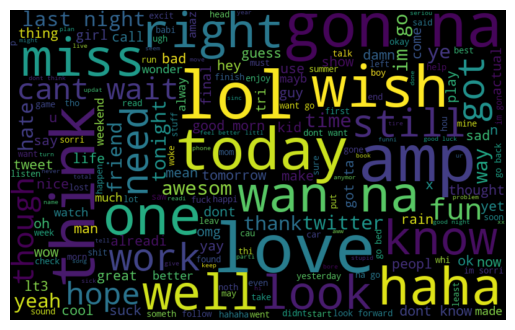

In [32]:
words = ' '.join([text for text in pandas_df['text']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

### Most used words in positive tweets

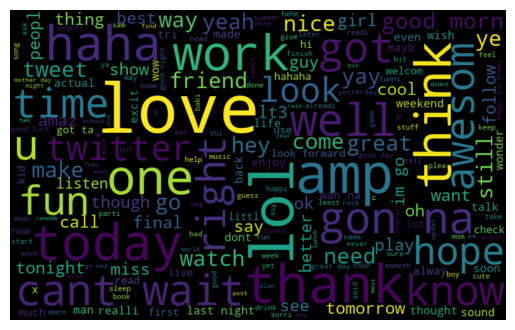

In [33]:
words = ' '.join([text for text in pandas_df[pandas_df['target']==1]['text']]) 
wordcloud = WordCloud(width=800, height=500, random_state=41, max_font_size=110).generate(words) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

### Most used words in negative tweets

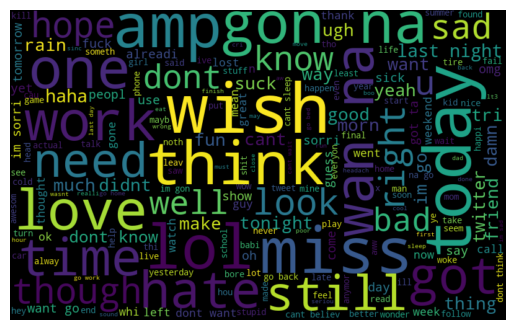

In [34]:
words = ' '.join([text for text in pandas_df[pandas_df['target']==0]['text']]) 
wordcloud = WordCloud(width=800, height=500, random_state=41, max_font_size=110).generate(words) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

## Machine Learning

### Embeddings
In NLP, `embedding` refers to representing words or text documents as numerical vectors in a continuous space. These learned representations capture semantic meaning and are used as input for machine learning models to process text data.<br><br>
`Word2vec` is a group of related models that are used to produce word embeddings

In [35]:
df = df.withColumn("text", split(df.text, " "))

In [36]:
word2vec = Word2Vec(vectorSize=50, minCount=5, inputCol="text", outputCol="embedding_vector")
word2vec_model = word2vec.fit(df)

In [37]:
df_embeddings = word2vec_model.transform(df)

In [38]:
df_embeddings = df_embeddings.drop("text")

In [39]:
df_embeddings.show(3)

+------+--------------------+
|target|    embedding_vector|
+------+--------------------+
|   0.0|[-0.0977534388445...|
|   0.0|[-0.0783233779172...|
|   0.0|[-0.1513700972621...|
+------+--------------------+
only showing top 3 rows



In [40]:
df_embeddings = df_embeddings.orderBy(rand(seed=42))

In [41]:
df_embeddings = df_embeddings.withColumn("index", monotonically_increasing_id())

### Data Split
Due to resource limitations, we used 10% of the data for the model.

In [42]:
a = []
for i in range(0, 50000, 10000):
    df_i = df_embeddings.where(df_embeddings.index.between(i,i+9999))
    X_i = np.array(df_i.select("embedding_vector").collect())
    a.append(X_i)

In [43]:
for i in range(50000, 100000, 10000):
    df_i = df_embeddings.where(df_embeddings.index.between(i,i+9999))
    X_i = np.array(df_i.select("embedding_vector").collect())
    a.append(X_i)

In [44]:
for i in range(100000, 150000, 10000):
    df_i = df_embeddings.where(df_embeddings.index.between(i,i+9999))
    X_i = np.array(df_i.select("embedding_vector").collect())
    a.append(X_i)

In [47]:
X = np.concatenate(a)

In [48]:
X.shape

(130000, 1, 50)

In [49]:
y = np.array(df_embeddings.limit(130000).select("target").collect())

In [50]:
X = X.astype('float32')
y = y.astype('float32')

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### Model building

In [53]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=False):
        return super().call(inputs, training=True)

In [54]:
model = Sequential([
    LSTM(128, input_shape=(1, 50)),
    Dense(1000, activation='relu'),
    MCDropout(rate=0.8),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense (Dense)               (None, 1000)              129000    
                                                                 
 mc_dropout (MCDropout)      (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 221,649
Trainable params: 221,649
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10)

Epoch 1/10
2925/2925 [==============================] - 8s 2ms/step - loss: 0.5841 - accuracy: 0.6865 - auc: 0.7553 - val_loss: 0.5660 - val_accuracy: 0.6998 - val_auc: 0.7748
Epoch 2/10
2925/2925 [==============================] - 7s 3ms/step - loss: 0.5659 - accuracy: 0.7002 - auc: 0.7759 - val_loss: 0.5613 - val_accuracy: 0.7101 - val_auc: 0.7843
Epoch 3/10
2925/2925 [==============================] - 7s 2ms/step - loss: 0.5577 - accuracy: 0.7091 - auc: 0.7849 - val_loss: 0.5511 - val_accuracy: 0.7165 - val_auc: 0.7937
Epoch 4/10
2925/2925 [==============================] - 7s 2ms/step - loss: 0.5515 - accuracy: 0.7124 - auc: 0.7902 - val_loss: 0.5509 - val_accuracy: 0.7137 - val_auc: 0.7957
Epoch 5/10
2925/2925 [==============================] - 7s 2ms/step - loss: 0.5467 - accuracy: 0.7189 - auc: 0.7953 - val_loss: 0.5466 - val_accuracy: 0.7176 - val_auc: 0.7964
Epoch 6/10
2925/2925 [==============================] - 7s 2ms/step - loss: 0.5442 - accuracy: 0.7196 - auc: 0.7971 - va

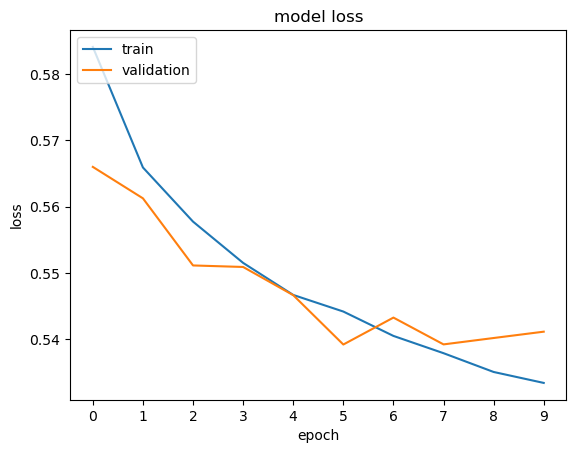

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [58]:
predictions = model.predict(X_test)

813/813 [==============================] - 1s 999us/step


In [59]:
predictions = [item[0] for item in predictions]

In [60]:
auc_score = roc_auc_score(y_test, predictions)
print(f'Our model yielded an AUC score of {auc_score}')

Our model yielded an AUC score of 0.7983804605720741


In [62]:
y_pred = predictions
for i in range(len(predictions)):
    if predictions[i]<0.5:
        y_pred[i] = 0
    else: 
        y_pred[i] = 1
accuracy = accuracy_score(y_test, y_pred)
print(f'Our model gave an accuracy of : {np.round(accuracy*100, 2)}%')

Our model gave an accuracy of : 71.77%


In [63]:
print('classification_report :')
print(classification_report(y_test, y_pred))

classification_report :
              precision    recall  f1-score   support

         0.0       0.69      0.80      0.74     12961
         1.0       0.76      0.63      0.69     13039

    accuracy                           0.72     26000
   macro avg       0.72      0.72      0.72     26000
weighted avg       0.72      0.72      0.72     26000



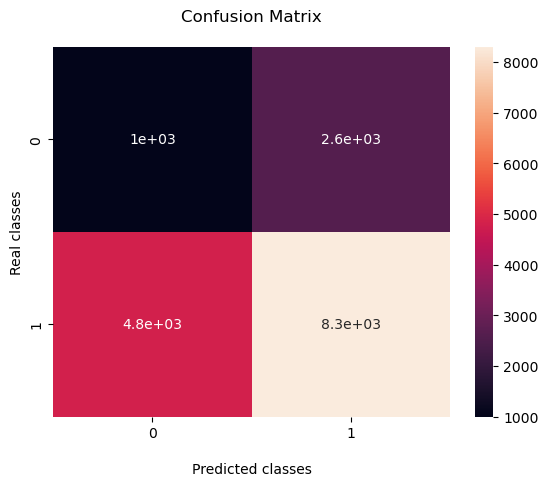

In [64]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted classes')
ax.set_ylabel('Real classes');

ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.show()